In [1]:
# Imported necessary libraries
import os
import pandas as pd
import numpy as np
import PyPDF2
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Downloaded NLTK data (like stopwords)
nltk.download('stopwords')
nltk.download('wordnet')

# NLTK tools
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yaswanth.p.lv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yaswanth.p.lv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Training Data

In [2]:
train_csv_file_path = 'output_file_names130.csv'

train_labels_df = pd.read_csv(train_csv_file_path)

#  5 rows of the DataFrame
print("First few rows of the training labels data:")
train_labels_df.head()


First few rows of the training labels data:


,File Name,Label
0,AD PLASTIK DD_annual report_2023.pdf,annual
1,ALPS ELECTRIC CO LTD_annual report_2023.pdf,annual
2,AMERICAN AXLE AND MANUFACTURING_annual report_...,annual
3,APTIV SERVICES US LLC_annual report_2023.pdf,annual
4,ARCELORMITTAL FLAT CARBON EUROPE S.A._annual r...,annual


In [5]:
train_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   File Name  160 non-null    object
 1   Label      160 non-null    object
dtypes: object(2)
memory usage: 2.6+ KB


#### Extraction Of text into DataFrame

In [4]:
train_pdf_folder_path = r'C:\Users\yaswanth.p.lv\Documents\MSV Web\train_80_both'

# Function to extract text from PDF
def extract_text_from_pdf(pdf_path):
    text = ""
    try:
        with open(pdf_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            for page_num in range(len(pdf_reader.pages)):
                page = pdf_reader.pages[page_num]
                text += page.extract_text() if page.extract_text() else ""
    except Exception as e:
        print(f"Error reading {pdf_path}: {e}")
    return text

# Loop through the training data, extract text from each PDF, and create a DataFrame
train_data = []
for _, row in train_labels_df.iterrows():
    file_name = row['File Name']
    label = row['Label']
    pdf_path = os.path.join(train_pdf_folder_path, file_name)
    text = extract_text_from_pdf(pdf_path)
    train_data.append({'text': text, 'label': label})

# Converting to DataFrame
train_df = pd.DataFrame(train_data)

#  first few rows of the DataFrame to confirm text extraction
print("First few rows of the extracted training data:")
train_df.head()


ignore '/Perms' verify failed
C:\Users\yaswanth.p.lv\AppData\Roaming\Python\Python312\site-packages\PyPDF2\_cmap.py:142: PdfReadWarning: Advanced encoding /UniKS-UTF16-H not implemented yet
  warnings.warn(


First few rows of the extracted training data:


,text,label
0,INTEGRATED \nANNUAL \nREPORT \n2022 GRI 2-3\nM...,annual
1,INTEGR ATED \nREPORT \n2023 \nPromotion Struct...,annual
2,\n1 \n \n \n \nAAM Reports Fourth Quarter a...,annual
3,2023 \nAnnual ReportTO OUR SHAREHOLDERS\nEvery...,annual
4,Table of Contents\nManagement report Page\nInt...,annual


#### EDA on Training Set

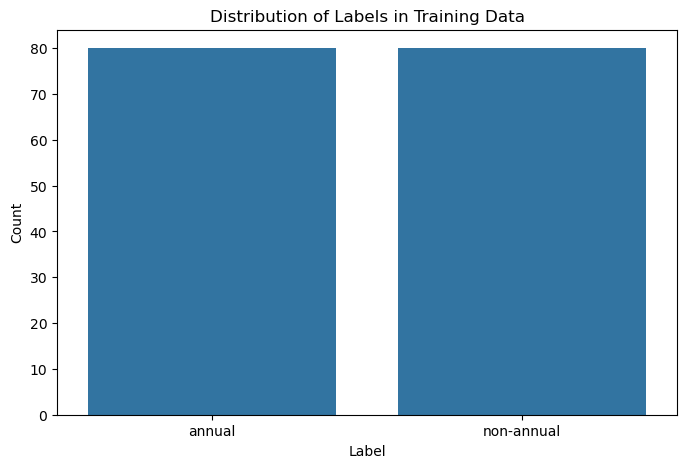

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of occurrences of each label
label_counts = train_df['label'].value_counts()

# Plot the distribution of labels
plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Distribution of Labels in Training Data")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

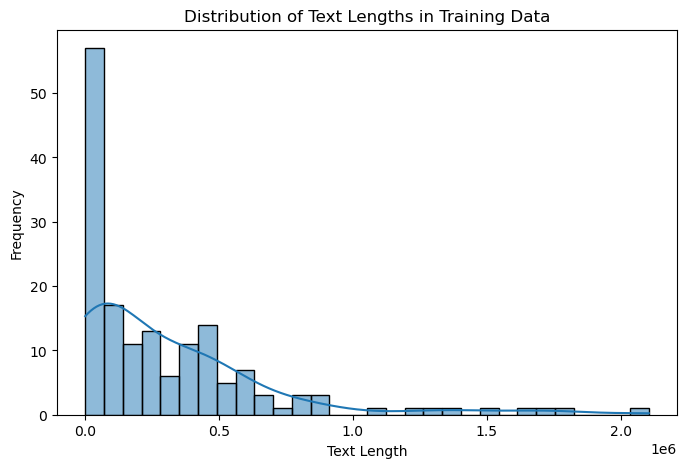

In [7]:
#  Check the length of the text data
train_df['text_length'] = train_df['text'].apply(len)

# Plot the distribution of text lengths
plt.figure(figsize=(8, 5))
sns.histplot(train_df['text_length'], bins=30, kde=True)
plt.title("Distribution of Text Lengths in Training Data")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show() 

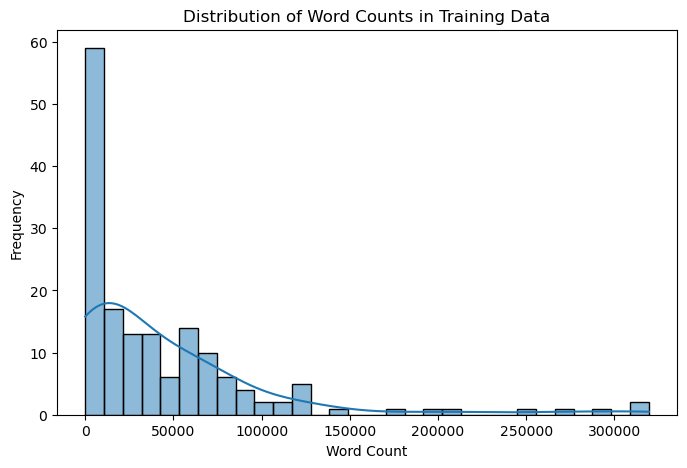

In [14]:
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 5))
sns.histplot(train_df['word_count'], bins=30, kde=True)
plt.title("Distribution of Word Counts in Training Data")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


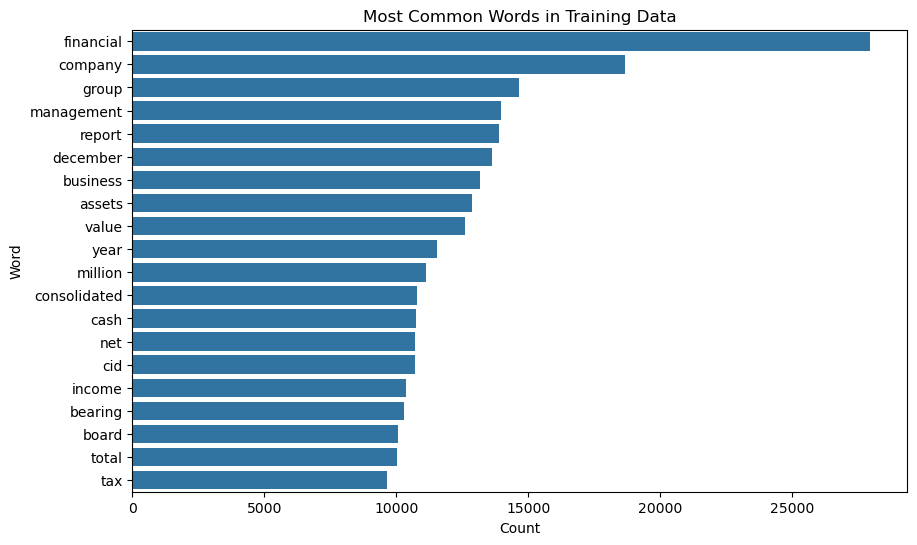

In [15]:
from collections import Counter
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))
all_words = ' '.join(train_df['text']).split()
all_words = [word.lower() for word in all_words if word.isalpha() and word.lower() not in stop_words]
common_words = Counter(all_words).most_common(20)

words, counts = zip(*common_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=counts, y=words)
plt.title("Most Common Words in Training Data")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()


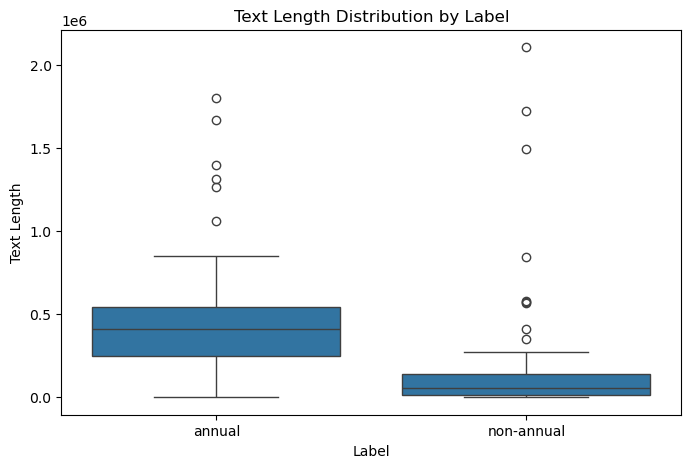

In [16]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='label', y='text_length', data=train_df)
plt.title("Text Length Distribution by Label")
plt.xlabel("Label")
plt.ylabel("Text Length")
plt.show()


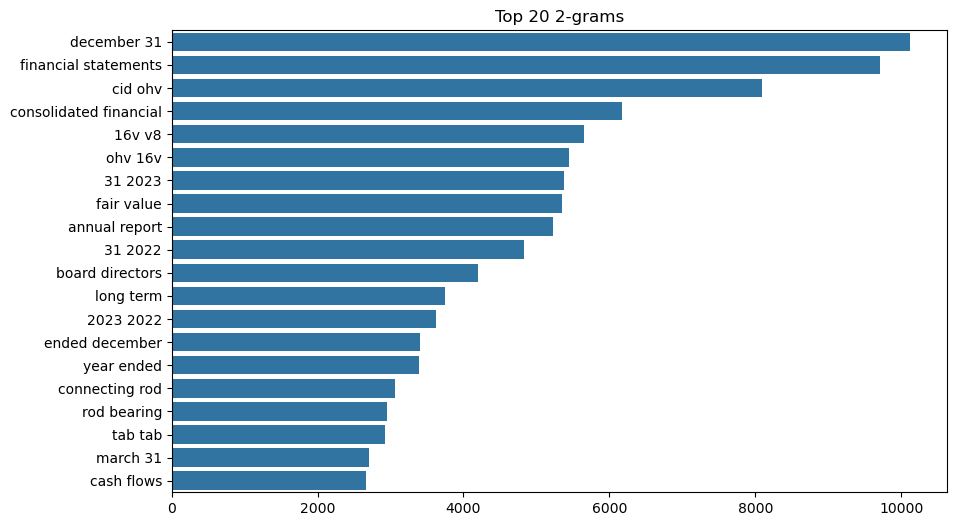

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_ngrams(corpus, ngram_range=(2, 2), n=20):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    top_ngrams = words_freq[:n]
    words, counts = zip(*top_ngrams)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts, y=words)
    plt.title(f"Top {n} {ngram_range[1]}-grams")
    plt.show()

plot_top_ngrams(train_df['text'], ngram_range=(2, 2))  # For bigrams


#### Text Preprocessing

In [8]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize text
    tokens = text.split()
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back to a single string
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# Apply preprocessing to the text column
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)

In [9]:
# the first few rows of the DataFrame with cleaned text
print("First few rows of the training data after preprocessing:")
train_df[['text', 'cleaned_text', 'label']].head()


First few rows of the training data after preprocessing:


,text,cleaned_text,label
0,INTEGRATED \nANNUAL \nREPORT \n2022 GRI 2-3\nM...,integrated annual report gri megi drezga janko...,annual
1,INTEGR ATED \nREPORT \n2023 \nPromotion Struct...,integr ated report promotion structureintegrat...,annual
2,\n1 \n \n \n \nAAM Reports Fourth Quarter a...,aam report fourth quarter full year financial ...,annual
3,2023 \nAnnual ReportTO OUR SHAREHOLDERS\nEvery...,annual reportto shareholder every year pace f ...,annual
4,Table of Contents\nManagement report Page\nInt...,table content management report page introduct...,annual


#### TFIDF VECTORIZATION

In [12]:
# Convert text to TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_features=1500) 
X = tfidf_vectorizer.fit_transform(train_df['cleaned_text']).toarray()

# Encode the labels into numeric values (0 for non-annual, 1 for annual)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_df['label'])

# Display the shapes of the feature matrix and label vector
print("Shape of the TF-IDF feature matrix:", X.shape)
print("Shape of the label vector:", y.shape)

Shape of the TF-IDF feature matrix: (160, 1500)
Shape of the label vector: (160,)


#### Testing Part

In [13]:
# Define the path to the testing labels CSV file
test_csv_file_path = 'output_file_names135.csv'  
# Load the testing labels CSV file into a DataFrame
test_labels_df = pd.read_csv(test_csv_file_path)

# Define the path to the testing PDF folder
test_pdf_folder_path = r'C:\Users\yaswanth.p.lv\Documents\MSV Web\test_25_both'

# Function to extract text from PDF (reusing the function defined earlier)
def extract_text_from_pdf(pdf_path):
    text = ""
    try:
        with open(pdf_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            for page_num in range(len(pdf_reader.pages)):
                page = pdf_reader.pages[page_num]
                text += page.extract_text() if page.extract_text() else ""
    except Exception as e:
        print(f"Error reading {pdf_path}: {e}")
    return text

# Loop through the testing data, extract text from each PDF, and create a DataFrame
test_data = []
for _, row in test_labels_df.iterrows():
    file_name = row['File Name']
    label = row['Label']
    pdf_path = os.path.join(test_pdf_folder_path, file_name)
    text = extract_text_from_pdf(pdf_path)
    test_data.append({'text': text, 'label': label})

# Convert to DataFrame
test_df = pd.DataFrame(test_data)

# Display the first few rows of the DataFrame to confirm text extraction
print("First few rows of the extracted testing data:")
test_df.head()

# Preprocess the text in the testing set
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)

# Convert test text to TF-IDF vectors
X_test = tfidf_vectorizer.transform(test_df['cleaned_text']).toarray()

# Encode the labels into numeric values
y_test = label_encoder.transform(test_df['label'])

# Display the shapes of the feature matrix and label vector for testing set
print("Shape of the TF-IDF feature matrix for testing set:", X_test.shape)
print("Shape of the label vector for testing set:", y_test.shape)


Error reading C:\Users\yaswanth.p.lv\Documents\MSV Web\test_25_both\HYUNDAI WIA MEXICO S DE RL DE CV_annual report_2023.pdf: trailer can not be read ()
First few rows of the extracted testing data:
Shape of the TF-IDF feature matrix for testing set: (50, 1500)
Shape of the label vector for testing set: (50,)


#### EDA on Testing Part

In [18]:
label_counts_test = test_df['label'].value_counts()

In [19]:
label_counts_test

label
annual        25
non-annual    25
Name: count, dtype: int64

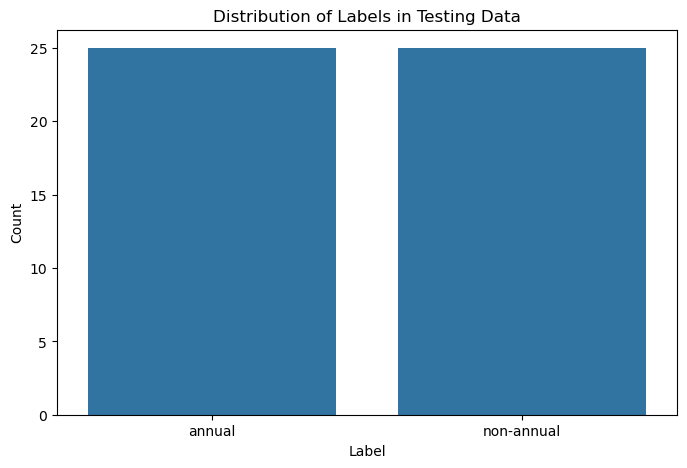

In [20]:
#  distribution of labels
plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts_test.index, y=label_counts_test.values)
plt.title("Distribution of Labels in Testing Data")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [23]:
# Sample Text 
print("Sample Text from Testing Data:")
print(test_df[['text', 'label']].sample(5))

Sample Text from Testing Data:
                                                 text       label
12  SHOWA DENKO Report  \n2022 Integrated ReportHO...      annual
49  This document is a translation into English of...  non-annual
27  AE 2.106:70/1--  .250/INDEX  \nGovernment  Dep...  non-annual
13  Annual Report 2022\nFocus on Future \nTechnolo...      annual
36              ANNUAL CORPORATE GOVERNANCE REPORT...  non-annual


In [25]:
pip install wordcloud

In [26]:
from wordcloud import WordCloud

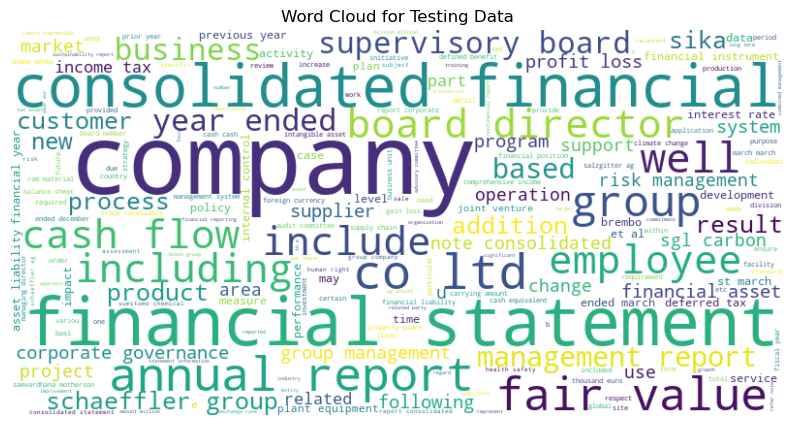

In [27]:
# . Word Cloud for Testing Data
plt.figure(figsize=(10, 6))
wordcloud_test = WordCloud(width=800, height=400, background_color='white').generate(' '.join(test_df['cleaned_text']))
plt.imshow(wordcloud_test, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Testing Data")
plt.show()

In [32]:
#  shapes of X and y
print("Shape of the feature matrix X (training set):", X.shape)
print("Shape of the label vector y (training labels):", y.shape)

# shapes of the test feature matrix and label vector
print("Shape of the feature matrix X_test (testing set):", X_test.shape)
print("Shape of the label vector y_test (testing labels):", y_test.shape)


Shape of the feature matrix X (training set): (160, 1500)
Shape of the label vector y (training labels): (160,)
Shape of the feature matrix X_test (testing set): (50, 1500)
Shape of the label vector y_test (testing labels): (50,)


#### Model Building

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialized the model
logistic_model = LogisticRegression(max_iter=1000)

logistic_model.fit(X, y)

# Predicted on the testing data
y_pred_logistic = logistic_model.predict(X_test)

# Evaluating the model
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print(f"Logistic Regression Accuracy: {accuracy_logistic:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_logistic))


Logistic Regression Accuracy: 0.88
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89        25
           1       0.95      0.80      0.87        25

    accuracy                           0.88        50
   macro avg       0.89      0.88      0.88        50
weighted avg       0.89      0.88      0.88        50



In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

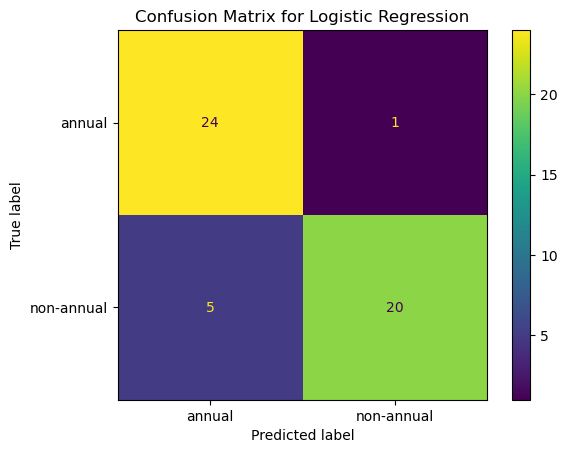

In [30]:
cm_logistic = confusion_matrix(y_test, y_pred_logistic)
ConfusionMatrixDisplay(cm_logistic, display_labels=label_encoder.classes_).plot()
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

#### Decision Tree Classifier

In [33]:
from sklearn.tree import DecisionTreeClassifier

# Initialized the model
decision_tree_model = DecisionTreeClassifier()

decision_tree_model.fit(X, y)

# Predicted on the testing data
y_pred_tree = decision_tree_model.predict(X_test)

# Evaluating the model
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f"Decision Tree Accuracy: {accuracy_tree:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_tree))

Decision Tree Accuracy: 0.84
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.88      0.85        25
           1       0.87      0.80      0.83        25

    accuracy                           0.84        50
   macro avg       0.84      0.84      0.84        50
weighted avg       0.84      0.84      0.84        50



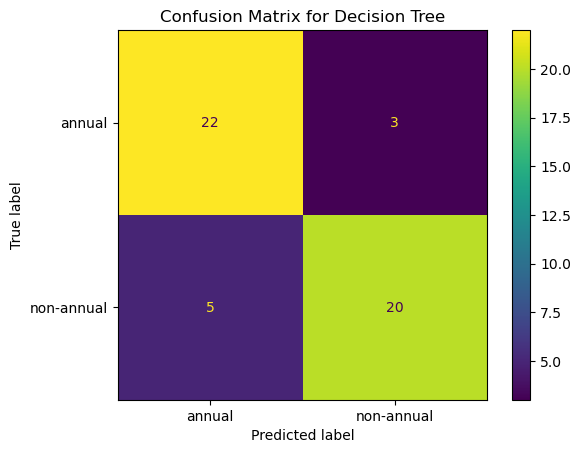

In [34]:
cm_tree = confusion_matrix(y_test, y_pred_tree)
ConfusionMatrixDisplay(cm_tree, display_labels=label_encoder.classes_).plot()
plt.title("Confusion Matrix for Decision Tree")
plt.show()

#### Random Forest Classifer 

In [35]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
random_forest_model = RandomForestClassifier(n_estimators=100)

random_forest_model.fit(X, y)

# Predicted on the testing data
y_pred_forest = random_forest_model.predict(X_test)

# Evaluating the model
accuracy_forest = accuracy_score(y_test, y_pred_forest)
print(f"Random Forest Accuracy: {accuracy_forest:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_forest))

Random Forest Accuracy: 0.92
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92        25
           1       0.96      0.88      0.92        25

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50



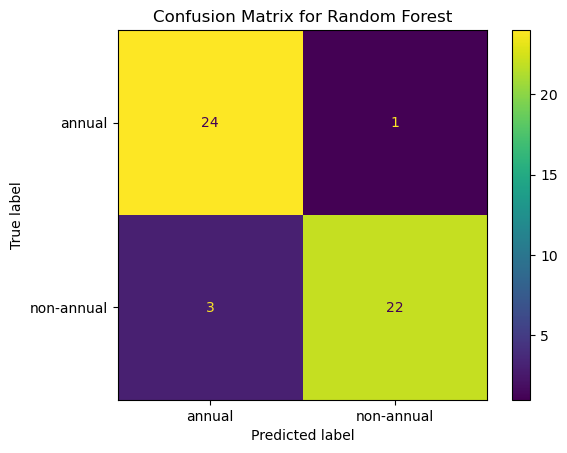

In [36]:
# Confusion Matrix
cm_forest = confusion_matrix(y_test, y_pred_forest)
ConfusionMatrixDisplay(cm_forest, display_labels=label_encoder.classes_).plot()
plt.title("Confusion Matrix for Random Forest")
plt.show()

In [37]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear') 

svm_model.fit(X, y)

# Predicted on the testing data
y_pred_svm = svm_model.predict(X_test)

# Evaluating the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.88
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89        25
           1       0.95      0.80      0.87        25

    accuracy                           0.88        50
   macro avg       0.89      0.88      0.88        50
weighted avg       0.89      0.88      0.88        50



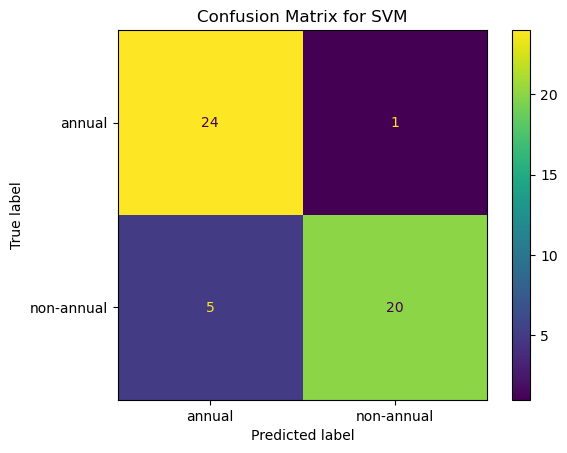

In [38]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
ConfusionMatrixDisplay(cm_svm, display_labels=label_encoder.classes_).plot()
plt.title("Confusion Matrix for SVM")
plt.show()

#### Gradient Boosting Classifier

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialized the model
gb_model = GradientBoostingClassifier()

# Fit the model on the training data
gb_model.fit(X, y)

# Predicting on the testing data
y_pred_gb = gb_model.predict(X_test)

# Evaluating the model
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Gradient Boosting Accuracy: {accuracy_gb:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_gb))

Gradient Boosting Accuracy: 0.88
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89        25
           1       0.95      0.80      0.87        25

    accuracy                           0.88        50
   macro avg       0.89      0.88      0.88        50
weighted avg       0.89      0.88      0.88        50



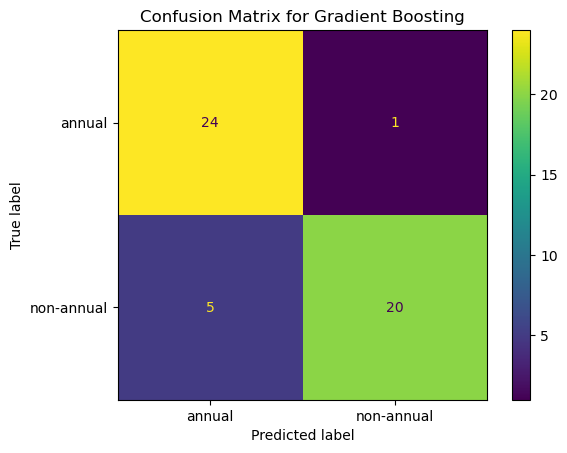

In [40]:
cm_gb = confusion_matrix(y_test, y_pred_gb)
ConfusionMatrixDisplay(cm_gb, display_labels=label_encoder.classes_).plot()
plt.title("Confusion Matrix for Gradient Boosting")
plt.show()

#### XGBoost

In [41]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

xgb_model.fit(X, y)

# Predicted on the testing data
y_pred_xgb = xgb_model.predict(X_test)

# Evaluating the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

C:\Users\yaswanth.p.lv\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [12:56:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.92
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92        25
           1       0.96      0.88      0.92        25

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50



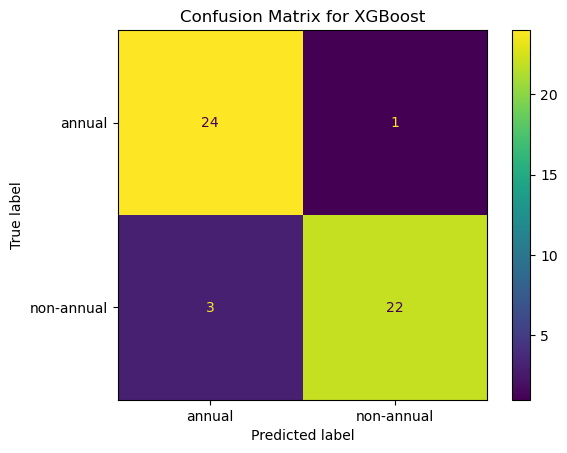

In [42]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
ConfusionMatrixDisplay(cm_xgb, display_labels=label_encoder.classes_).plot()
plt.title("Confusion Matrix for XGBoost")
plt.show()

#### LightGBM

In [43]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier()

lgb_model.fit(X, y)

# Predicted on the testing data
y_pred_lgb = lgb_model.predict(X_test)

# Evaluating the model
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print(f"LightGBM Accuracy: {accuracy_lgb:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_lgb))


[LightGBM] [Info] Number of positive: 80, number of negative: 80
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43124
[LightGBM] [Info] Number of data points in the train set: 160, number of used features: 1379
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

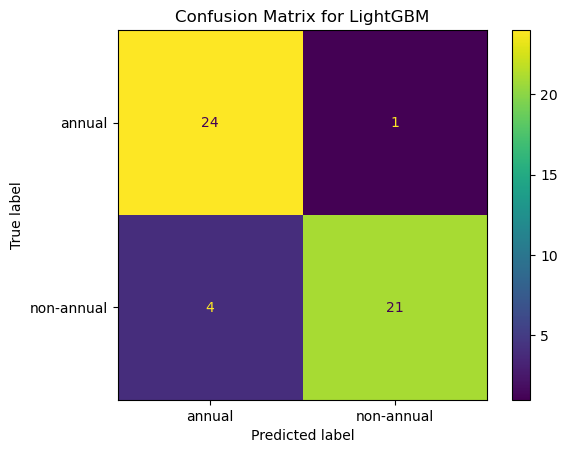

In [44]:
cm_lgb = confusion_matrix(y_test, y_pred_lgb)
ConfusionMatrixDisplay(cm_lgb, display_labels=label_encoder.classes_).plot()
plt.title("Confusion Matrix for LightGBM")
plt.show()

#### CatBoost

In [46]:
!pip install catboost

   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.8/101.7 MB 8.5 MB/s eta 0:00:12
    --------------------------------------- 1.3/101.7 MB 6.1 MB/s eta 0:00:17
   - -------------------------------------- 2.6/101.7 MB 4.7 MB/s eta 0:00:22
   - -------------------------------------- 2.9/101.7 MB 4.5 MB/s eta 0:00:22
   - -------------------------------------- 3.7/101.7 MB 3.9 MB/s eta 0:00:26
   - -------------------------------------- 4.2/101.7 MB 4.1 MB/s eta 0:00:25
   -- ------------------------------------- 5.2/101.7 MB 3.8 MB/s eta 0:00:26
   -- ------------------------------------- 6.0/101.7 MB 3.8 MB/s eta 0:00:26
   -- ------------------------------------- 6.8/101.7 MB 3.8 MB/s eta 0:00:25
   -- ------------------------------------- 7.6/101.7 MB 3.8 MB/s eta 0:00:25
   --- ------------------------------------ 8.4/101.7 MB 3.8 MB/s eta 0:00:25
   --- ------------------------------------ 9.2/101.7 MB 3.8 MB/s eta 0

In [47]:
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(silent=True)

catboost_model.fit(X, y)

# Predicted on the testing data
y_pred_catboost = catboost_model.predict(X_test)

# Evaluating the model
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
print(f"CatBoost Accuracy: {accuracy_catboost:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_catboost))

CatBoost Accuracy: 0.90
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.96      0.91        25
           1       0.95      0.84      0.89        25

    accuracy                           0.90        50
   macro avg       0.91      0.90      0.90        50
weighted avg       0.91      0.90      0.90        50



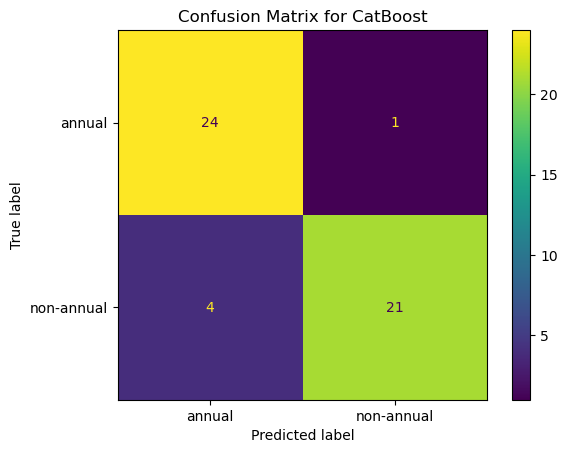

In [48]:
cm_catboost = confusion_matrix(y_test, y_pred_catboost)
ConfusionMatrixDisplay(cm_catboost, display_labels=label_encoder.classes_).plot()
plt.title("Confusion Matrix for CatBoost")
plt.show()

#### Implementation of LSTM

In [49]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [52]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Define parameters
max_words = 5000  # Max number of words to consider
max_len = 100  # Max length of sequences

# Tokenize the text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['cleaned_text'])


In [53]:
# Convert text to sequences
X_seq = tokenizer.texts_to_sequences(train_df['cleaned_text'])
X_seq_test = tokenizer.texts_to_sequences(test_df['cleaned_text'])

In [54]:
# Pad sequences to ensure uniform input length
X_pad = pad_sequences(X_seq, maxlen=max_len)
X_pad_test = pad_sequences(X_seq_test, maxlen=max_len)


In [55]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(train_df['label'])
y_encoded_test = label_encoder.transform(test_df['label'])

In [56]:
# Check the shapes
print("Shape of padded training data:", X_pad.shape)
print("Shape of padded testing data:", X_pad_test.shape)

Shape of padded training data: (160, 100)
Shape of padded testing data: (50, 100)


In [58]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))  # Specify input length
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))  # Use 'softmax' for multi-class

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ ?                           │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [60]:
from tensorflow.keras.preprocessing.text import Tokenizer


In [62]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Parameters
max_words = 1500  # Adjust this based on your dataset
max_len = 100     # Maximum length of sequences

# Initialize Tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['cleaned_text'])  # Use the cleaned text for training

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(train_df['cleaned_text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['cleaned_text'])

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len)

# Display shapes of padded sequences
print("Shape of padded training data:", X_train_padded.shape)
print("Shape of padded testing data:", X_test_padded.shape)


Shape of padded training data: (160, 100)
Shape of padded testing data: (50, 100)


In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D


In [65]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))  # Embedding layer
model.add(SpatialDropout1D(0.2))  # Dropout layer for regularization
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))  # LSTM layer
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_3                  │ ?                           │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D

In [67]:
max_words = 1500  # Adjust this based on your dataset
max_len = 100     # Maximum length of sequences

In [68]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Initialize Tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['cleaned_text'])  # Use the cleaned text for training

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(train_df['cleaned_text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['cleaned_text'])

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len)


In [69]:
print("Shape of padded training data:", X_train_padded.shape)
print("Shape of padded testing data:", X_test_padded.shape)


Shape of padded training data: (160, 100)
Shape of padded testing data: (50, 100)


In [70]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D

# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))  # Embedding layer
model.add(SpatialDropout1D(0.2))  # Dropout layer for regularization
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))  # LSTM layer
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_4                  │ ?                           │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)